# 연결 재무제표에서 자본총계와 부채총계값을 추출해서 그래프를 만듭니다

In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
print('사업보고서가 저장된 회사:')
#폴더명을 먼저 가져옵니다 (형식: 'dart_[회사명]')
folderitems = os.listdir()
#회사명만 분리해 목록을 뽑습니다
for item in folderitems:
    if '.' not in item:
        if item.startswith('dart_'):
            print("- "+item.replace('dart_',''))

사업보고서가 저장된 회사:
- LG전자
- 기아자동차
- 넥슨지티
- 메가스터디
- 메디톡스
- 미래컴퍼니
- 바이로메드
- 삼성전자
- 삼성출판사
- 셀트리온헬스케어
- 신라젠
- 코리안리
- 태림포장
- 한국제지
- 현대자동차
- 휠라코리아


In [3]:
inputcompany=input('저장된 사업보고서 중 조사하고자 하는 회사명을 입력해주세요:')
testfile = 'dart_'+inputcompany+'/'
while testfile.replace('/','') not in folderitems:
    inputcompany=input('존재하는 회사명으로 다시 입력해주세요. ')
    testfile = 'dart_'+inputcompany+'/'

In [4]:
#각 폴더 내에 있는 엑셀파일을 찾아 디렉토리 목록을 저장합니다
linklist=[]
for item in os.listdir(testfile):
    sublist = os.listdir(testfile+item)
    for item2 in sublist:
        if item2.endswith('.xls'):
            filedirectory = testfile+item+"/"+item2
            linklist.append(filedirectory)

In [5]:
if len(linklist) < 1:
    print('사업보고서가 존재하지 않습니다.')
else:
    first_year = linklist[0].split('/')[1].split('(')[1].split('.')[0]
    first_month = linklist[0].split('/')[1].split('(')[1].split('.')[1].replace(')','')
    current_year = linklist[-1].split('/')[1].split('(')[1].split('.')[0]
    accounting_month = linklist[-1].split('/')[1].split('(')[1].split('.')[1].replace(')','')
    print('총 '+str(len(linklist))+'개의 크롤링 가능한 엑셀파일 ('+first_year+'년 '+first_month+'월 ~ '+current_year+'년 '+accounting_month+'월)')

총 10개의 크롤링 가능한 엑셀파일 (2007년 12월 ~ 2016년 12월)


In [6]:
#각 행을 스캔해 "제 XX 기" 같은 표현이 등장하는 횟수를 score로 저장함 (엑셀시트 형식 당 skiprows를 해야 하는 숫자가 달라서 이걸 자동으로 찾아주기 위함)
r_col = re.compile(r'제\s*\d{1,}\s*기')
def header_score(row):
    score=0
    for k,item in row.items():
        if len(r_col.findall(str(item))) !=0:
            score+=1
    return score

#TODO: 단위를 찾아주는 function을 만들어야 하는데... 머리가 아프다...

#"제 XX 기" 표현이 가장 많이 등장하는 행을 header로 선정함
def get_right_header(df):
    header_row = df.fillna('').apply(header_score,axis=1).argmax()
    newdf = df.iloc[header_row+1:]
    newdf.columns = df.iloc[header_row].values
    return newdf

## 1. 재무제표 크롤링

In [7]:
#재무 테이블을 깔끔하게 정리해주는 function
def clean_table(jaemu):
    #Changing the first column name to category
    oldname = jaemu.columns[0]
    clean = jaemu.rename(columns={oldname:'category'})
    clean['category'] = clean.category.apply(str.strip)
    indexlist = []
    for index,row in clean.iterrows():
        if (row.category == '부채총계') | (row.category == '자본총계'):
            indexlist.append(index)
    clean2 = clean.iloc[indexlist].copy()
    return clean2

In [8]:
def get_jaemu(wholetable, year):
    wholetable_sheets = list(wholetable.keys())
    if '대차대조표' in wholetable_sheets:
        a = get_right_header(wholetable['대차대조표']).reset_index(drop=True)
        print(str(year)+'년: 대차대조표')
    elif '연결 재무상태표' in wholetable_sheets:
        a = get_right_header(wholetable['연결 재무상태표']).reset_index(drop=True)
        print(str(year)+'년: 연결 재무상태표')
    elif '재무상태표' in wholetable_sheets:
        a = get_right_header(wholetable['재무상태표']).reset_index(drop=True)
        print(str(year)+'년: 재무상태표')
    else:
        b = wholetable_sheets[1]
        print(str(year)+"년: "+b+"(?)")
        a = get_right_header(wholetable[b]).reset_index(drop=True)
    return clean_table(a)

In [9]:
getall = pd.DataFrame()
#RegEx를 이용해서 '제 XX 기' (또는 '제XX기')로 명시된 기수를 숫자로 따로 추출합니다
r = re.compile(r'(\d+)')
year_tracker = int(first_year)
for item in linklist:
    table = pd.read_excel(item, sheetname=None)
    a = get_jaemu(table,year_tracker)
    year_tracker+=1
    melted = pd.melt(a, id_vars='category')
    #RegEx 이용 부분...
    melted['variable'] = melted.variable.apply(lambda x: r.findall(x)[0])
    #위에서 만든 getsummary DataFrame에다가 append
    getall = getall.append(melted).reset_index(drop=True).drop_duplicates()

2007년: 대차대조표
2008년: 대차대조표
2009년: 대차대조표
2010년: 대차대조표
2011년: 연결 재무상태표
2012년: 연결 재무상태표
2013년: 연결 재무상태표
2014년: 연결 재무상태표
2015년: 연결 재무상태표
2016년: 연결 재무상태표


In [10]:
#Datatype 수정 (금액은 float, 기수는 int로 변경)
getall['value'] = getall.value.astype(float)
getall['variable'] = getall.variable.astype(int)

In [11]:
#폴더명에서 추출한 최근 연도를 가지고 각 '기'에다가 더할 숫자를 구하고 (28기가 2016년이면 1988를 모든 '기'에 더해주면 연도가 나옴) 'variable' 열을 연도로 업데이트시켜줌
addnumber = int(current_year)-max(getall.variable)
getall['variable'] = getall.variable + addnumber

In [12]:
#pivot을 통해 그래프를 그리기 위한 적절한 형식의 dataframe를 만들어줌
jaemutable = pd.pivot_table(getall,index='variable',values='value',columns='category').rename(columns={'부채총계':'total_debt','자본총계':'total_equity'})

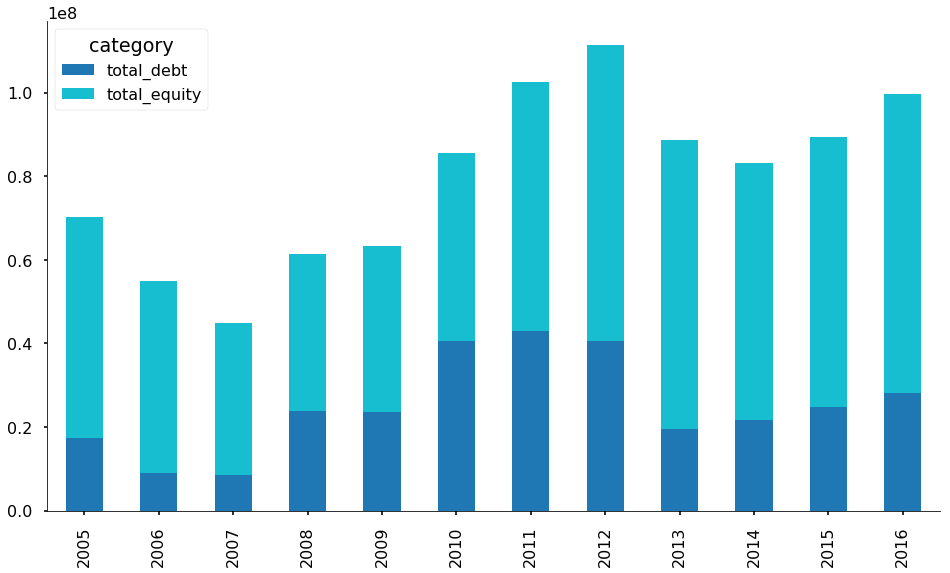

In [13]:
#그래프 그리기
sns.set_context('poster')
plt.figure(figsize=(16,9))
jaemutable.plot.bar(stacked=True,ax=plt.gca(),colormap='tab10')
plt.xlabel('')
sns.despine()

## 2. 손익계산서 크롤링

In [14]:
#손익계산서를 깔끔하게 정리해주는 function
def clean_sonik(df):
    #Changing the first column name to category
    oldname = df.columns[0]
    clean = df.rename(columns={oldname:'category'})
    clean['category'] = clean.category.apply(str.strip)
    indexlist = []
    for index,row in clean.iterrows():
        if row.category.find('매출액') != -1:
            indexlist.append(index)
        if row.category.find('매출') != -1:
            indexlist.append(index)
    if len(indexlist) != 1:
        indexlist = indexlist[:1]
    for index,row in clean.iterrows():
        if row.category.find('영업이익') != -1:
            indexlist.append(index)
    clean2 = clean.loc[indexlist].copy()
    #TODO: 매출액은 두 개 이상 있으면 맨 처음 것이어야 하고
    if len(clean2) !=2:
        clean2 = clean2[:2]
    return clean2

In [15]:
def get_sonik(wholetable, year):
    wholetable_sheets = list(wholetable.keys())
    if '손익계산서' in wholetable_sheets:
        a = get_right_header(wholetable['손익계산서']).reset_index(drop=True)
        print(str(year)+'년: 손익계산서')
    elif '포괄손익계산서' in wholetable_sheets:
        a = get_right_header(wholetable['포괄손익계산서']).reset_index(drop=True)
        print(str(year)+'년: 포괄손익계산서')
    elif '연결 포괄손익계산서' in wholetable_sheets:
        a = get_right_header(wholetable['연결 포괄손익계산서']).reset_index(drop=True)
        print(str(year)+'년: 연결 포괄손익계산서')
    else:
        for item in wholetable_sheets:
            if item.find('손익계산서') != -1:
                a = get_right_header(wholetable[item]).reset_index(drop=True)
                print(str(year)+'년: 손익계산서가 포함된 시트명')
            else:
                print(str(year)+"년: 손익계산서를 찾지 못함")
                a=pd.DataFrame()
    return clean_sonik(a)

In [16]:
#하나의 DataFrame로 통합하기 위해 빈 DataFrame을 우선 생성합니다
soniksummary = pd.DataFrame()
#RegEx를 이용해서 '제 XX 기' (또는 '제XX기')로 명시된 기수를 숫자로 따로 추출합니다
r = re.compile(r'(\d+)')
#재무제표 엑셀파일이 존재하는 모든 폴더에 걸쳐, 위에서 만든 function을 이용해 정보를 가져오고 정리합니다
year_tracker = int(first_year)
for item in linklist:
    table = pd.read_excel(item, sheetname=None)
    get_table = get_sonik(table, year_tracker)
    year_tracker+=1
    #좀 더 정돈된 정보를 위해 기수를 하나의 열로 만들어줍니다 (melt function 이용)
    melted = pd.melt(get_table, id_vars='category')
    #RegEx 이용 부분...
    melted['variable'] = melted.variable.apply(lambda x: r.findall(x)[0])
    #위에서 만든 getsummary DataFrame에다가 append
    soniksummary = soniksummary.append(melted).reset_index(drop=True).drop_duplicates()

2007년: 손익계산서
2008년: 손익계산서
2009년: 손익계산서
2010년: 손익계산서
2011년: 포괄손익계산서
2012년: 포괄손익계산서
2013년: 포괄손익계산서
2014년: 포괄손익계산서
2015년: 포괄손익계산서
2016년: 포괄손익계산서


In [17]:
def rename_values(x):
    if (x.find('매출') >= 0) or (x.find('영업수익') >=0):
        return 'sales'
    if x.find('영업이익') >=0:
        return 'operating_profit'
    return x

In [18]:
soniksummary['category'] = soniksummary.category.apply(rename_values)

In [19]:
#Datatype 수정 (금액은 float, 기수는 int로 변경)
soniksummary['value'] = soniksummary.value.astype(float)
soniksummary['variable'] = soniksummary.variable.astype(int)

In [20]:
#폴더명에서 추출한 최근 연도를 가지고 각 '기'에다가 더할 숫자를 구하고 (28기가 2016년이면 1988를 모든 '기'에 더해주면 연도가 나옴) 'variable' 열을 연도로 업데이트시켜줌
addnumber = int(current_year)-max(soniksummary.variable)
soniksummary['variable'] = soniksummary.variable + addnumber

In [21]:
#pivot을 통해 그래프를 그리기 위한 적절한 형식의 dataframe를 만들어줌
sonikpivot = pd.pivot_table(soniksummary,index='variable',values='value',columns='category')

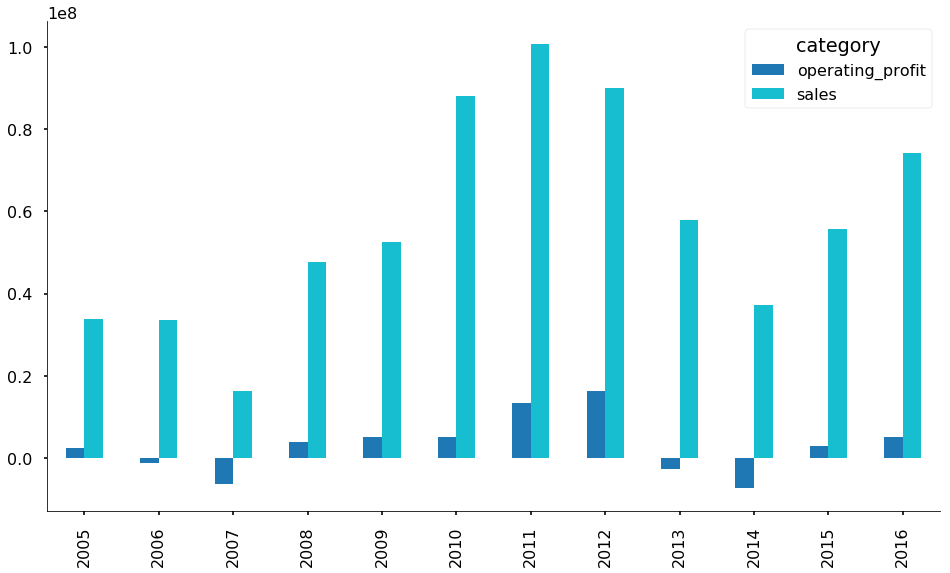

In [22]:
#그래프 그리기
sns.set_context('poster')
plt.figure(figsize=(16,9))
sonikpivot.plot.bar(stacked=False,ax=plt.gca(),colormap='tab10')
plt.xlabel('')
sns.despine()